In [30]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [31]:
performe_visualization = True

In [32]:
# some important parameters
pre_day = 5
window_size = 12*24*7 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    #"metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    #"metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [33]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [34]:
visualize_failure_timeline(failure_sessions)

In [35]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

Visualizing devices: 100%|██████████| 16/16 [00:50<00:00,  3.14s/it]

Visualization saved at visualization/raw_data/*.html


In [36]:
failure_sessions = failure_sessions[failure_sessions['maintenance'] == False]

### Downsampling

In [37]:
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

In [38]:
downsampled_data = downsample_inverter_raw(filtered_data, drop_empty_bins=False)

Downsampling 6126272 rows using following method: 
                          Column Aggregation
0  metric.AC_VOLTAGE_AB.MEASURED        mean
1  metric.AC_VOLTAGE_BC.MEASURED        mean
2  metric.AC_VOLTAGE_CA.MEASURED        mean
3     metric.DC_VOLTAGE.MEASURED        mean
4       metric.AC_POWER.MEASURED        mean


In [39]:
downsampled_data

,event_local_time,device_name,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED
0,2021-12-02 00:00:00,INV 51,NaN,NaN,NaN,NaN,NaN
1,2021-12-02 00:30:00,INV 51,34600.000000,34600.000000,34600.000000,6552.686035,0.0
2,2021-12-02 01:00:00,INV 51,NaN,NaN,NaN,NaN,NaN
3,2021-12-02 01:30:00,INV 51,NaN,NaN,NaN,NaN,NaN
4,2021-12-02 02:00:00,INV 51,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1021435,2025-07-23 21:30:00,INV 66,34283.332031,34283.332031,34283.332031,2.183333,0.0
1021436,2025-07-23 22:00:00,INV 66,34200.000000,34200.000000,34200.000000,2.037213,0.0
1021437,2025-07-23 22:30:00,INV 66,34300.746094,34300.746094,34300.746094,2.100000,0.0
1021438,2025-07-23 23:00:00,INV 66,34516.667969,34516.667969,34516.667969,2.263698,0.0


In [40]:
if performe_visualization or True:
    # Visualize the downsampled data
    visualize_hourly_mean_values(downsampled_data, failure_sessions, feature_cols, 'visualization', 'downsampled_data')

Visualizing devices: 100%|██████████| 16/16 [00:41<00:00,  2.58s/it]

Visualization saved at visualization/downsampled_data/*.html


### Data Cleaning

In [41]:
print("inverter_data shape:", downsampled_data.shape)
filtered_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", filtered_data.shape)

inverter_data shape: (1021440, 7)
Excluded 2 periods, remaining data size: 862464
Excluded data shape: (862464, 7)


In [42]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (32, 6)
Excluded 2 periods, remaining data size: 27
Excluded 2 periods, remaining data size: 27
failure_sessions shape: (27, 7)


In [43]:
visualize_failure_timeline(filtered_sessions)

In [44]:
# remove unused columns
filtered_data = filtered_data[['event_local_time', 'device_name'] + feature_cols]

In [45]:
if performe_visualization:
    # Visualize the filtered data
    visualize_hourly_mean_values(filtered_data, failure_sessions, feature_cols, 'visualization', 'filtered_data')

Visualizing devices: 100%|██████████| 16/16 [00:35<00:00,  2.21s/it]

Visualization saved at visualization/filtered_data/*.html


### Anomoly Detection

In [46]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

### Data Labeling

In [60]:
labeled_df = prepare_dataset(filtered_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6148
Total rows: 853905


### Missing Value Imputation

In [61]:
imputed_df = missing_value_imputation(labeled_df, feature_cols, time_col='event_local_time', device_col='device_name', short_gap_limit=0, long_fill_value=0.0, add_missing_mask=True)

In [62]:
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

In [63]:
imputed_df

,event_local_time,device_name,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED,label,metric.AC_VOLTAGE_AB.MEASURED_missing,metric.AC_VOLTAGE_BC.MEASURED_missing,metric.AC_VOLTAGE_CA.MEASURED_missing,metric.DC_VOLTAGE.MEASURED_missing,metric.AC_POWER.MEASURED_missing
0,2021-12-24 00:00:00,INV 51,34400.171875,34400.000000,34400.000000,12.439572,0.0,0,0.0,0.0,0.0,0.0,0.0
1,2021-12-24 00:30:00,INV 51,34186.058594,34185.386719,34185.386719,41.699497,0.0,0,0.0,0.0,0.0,0.0,0.0
2,2021-12-24 01:00:00,INV 51,34186.824219,34186.449219,34186.449219,3.771897,0.0,0,0.0,0.0,0.0,0.0,0.0
3,2021-12-24 01:30:00,INV 51,34367.199219,34367.480469,34367.480469,4.273490,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-12-24 02:00:00,INV 51,34101.886719,34101.933594,34101.933594,29.879051,0.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853900,2025-07-23 21:30:00,INV 66,34283.332031,34283.332031,34283.332031,2.183333,0.0,0,0.0,0.0,0.0,0.0,0.0
853901,2025-07-23 22:00:00,INV 66,34200.000000,34200.000000,34200.000000,2.037213,0.0,0,0.0,0.0,0.0,0.0,0.0
853902,2025-07-23 22:30:00,INV 66,34300.746094,34300.746094,34300.746094,2.100000,0.0,0,0.0,0.0,0.0,0.0,0.0
853903,2025-07-23 23:00:00,INV 66,34516.667969,34516.667969,34516.667969,2.263698,0.0,0,0.0,0.0,0.0,0.0,0.0


### Feature Engineering

In [64]:
imputed_df['hour_of_day'] = imputed_df['event_local_time'].dt.hour
imputed_df['month_of_year'] = imputed_df['event_local_time'].dt.month
extended_feature_cols += ['hour_of_day', 'month_of_year']


In [65]:
if performe_visualization:
    visualize_hourly_mean_values(imputed_df, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data')

Visualizing devices:   0%|          | 0/16 [00:00<?, ?it/s]

Visualizing devices: 100%|██████████| 16/16 [01:22<00:00,  5.15s/it]

Visualization saved at visualization/processed_data/*.html


### Split Dataset

In [66]:
train_df = imputed_df[imputed_df['event_local_time'] <= pd.Timestamp('2023-12-15')].copy()
val_df = imputed_df[(imputed_df['event_local_time'] > pd.Timestamp('2023-12-15')) & (imputed_df['event_local_time'] <= pd.Timestamp('2024-07-31'))].copy()
test_df = imputed_df[imputed_df['event_local_time'] > pd.Timestamp('2024-07-31')].copy()

In [54]:
#train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
#val_df, test_df = train_test_split_on_time(test_df, 0.3)

In [67]:
extended_feature_cols

['metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_of_day',
 'month_of_year']

### Standardization

In [68]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day', 'month_of_year']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [69]:
if performe_visualization:
    visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data')
    visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data')
    visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data')

Visualizing devices: 100%|██████████| 16/16 [00:39<00:00,  2.50s/it]


Visualization saved at visualization/train_data/*.html


Visualizing devices: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


Visualization saved at visualization/val_data/*.html


Visualizing devices: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]

Visualization saved at visualization/test_data/*.html


In [59]:
train_df['label'].value_counts()

0    555863
1      3988
Name: label, dtype: int64

### Create Dataset/Data Loader

In [70]:
stride = 1
window_size = 2*24*7 # 30 minutes * 24 * 7 = 1 week

In [71]:
positive_train_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)
negative_train_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)

Processing devices: 100%|██████████| 16/16 [00:01<00:00,  8.61it/s]


In [72]:
from torch.utils.data import DataLoader


train_ds = combine_dataset([positive_train_ds, negative_train_ds])
del positive_train_ds, negative_train_ds

val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:01<00:00, 12.70it/s]


In [73]:
train_ds.X.shape

torch.Size([391875, 336, 12])

In [74]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    389465
 1.0      2410
 dtype: int64,
 0.0    165672
 1.0      1440
 dtype: int64,
 0.0    263035
 1.0      1920
 dtype: int64)

In [79]:
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler
import torch

num_samples = int(len(train_ds)*0.1 ) # 10% of the training dataset size

# 假設 y 是樣本的 label 張量
class_sample_count = pd.value_counts(train_ds.y.numpy())
weights = 1. / class_sample_count
sample_weights = weights[train_ds.y.numpy()].to_numpy() # 每個樣本對應的抽樣權重

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_samples,
    replacement=True
)
print(weights, num_samples)

0.0    0.000003
1.0    0.000415
dtype: float64 39187


In [ ]:
random_sampler = RandomSampler(val_ds, num_samples=int(len(val_ds)*0.1), replacement=True)

In [81]:
batch_size = 2**9

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=balanced_sampler,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, sampler=random_sampler, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [84]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 建議先用較溫和的 pos_weight（例：5），再用驗證集掃描最佳值
pos_weight_value = 2.0
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float)).to('cuda')


In [ ]:
#model.load_state_dict(torch.load(r'model\0812_0003\epoch_15.pth', weights_only=True))

In [108]:
log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=10, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=1,
    save_path=r'model\0813_0202'
)

Model moved to cuda
Resuming training from epoch 41
[Epoch 41/10] Step 0/77 - Loss: 0.0711
[Epoch 41/10] Step 25/77 - Loss: 0.0360
[Epoch 41/10] Step 50/77 - Loss: 0.0366
[Epoch 41/10] Step 75/77 - Loss: 0.0296
🔁 Epoch 41 finished. Avg Train Loss: 0.0372
✅ Validation Loss: 0.2319 | Accuracy: 98.92% | AUC-PR: 0.0103
[Epoch 42/10] Step 0/77 - Loss: 0.0258
[Epoch 42/10] Step 25/77 - Loss: 0.0706
[Epoch 42/10] Step 50/77 - Loss: 0.1180
[Epoch 42/10] Step 75/77 - Loss: 0.0361
🔁 Epoch 42 finished. Avg Train Loss: 0.0551
✅ Validation Loss: 0.2181 | Accuracy: 98.84% | AUC-PR: 0.0137
[Epoch 43/10] Step 0/77 - Loss: 0.0543
[Epoch 43/10] Step 25/77 - Loss: 0.0476
[Epoch 43/10] Step 50/77 - Loss: 0.0461
[Epoch 43/10] Step 75/77 - Loss: 0.0439
🔁 Epoch 43 finished. Avg Train Loss: 0.0470
✅ Validation Loss: 0.2506 | Accuracy: 98.76% | AUC-PR: 0.0139
[Epoch 44/10] Step 0/77 - Loss: 0.0193
[Epoch 44/10] Step 25/77 - Loss: 0.0185
[Epoch 44/10] Step 50/77 - Loss: 0.0515
[Epoch 44/10] Step 75/77 - Loss: 0

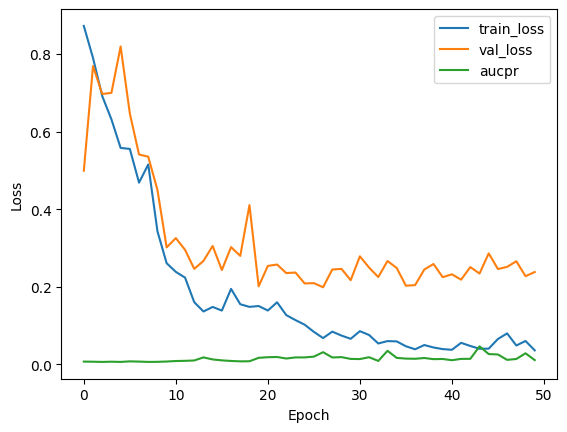

In [109]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [115]:
model.load_state_dict(torch.load(r'model\0813_0202\best_model.pth', weights_only=True))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



<All keys matched successfully>

Performance on Training Set:


Testing: 100%|██████████| 77/77 [00:10<00:00,  7.30it/s]


🔍 Test Loss: 0.0322 | Accuracy: 99.25%
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     19527
     Failure       0.99      1.00      0.99     19660

    accuracy                           0.99     39187
   macro avg       0.99      0.99      0.99     39187
weighted avg       0.99      0.99      0.99     39187

[[19233   294]
 [    0 19660]]
ROC AUC: 0.9986


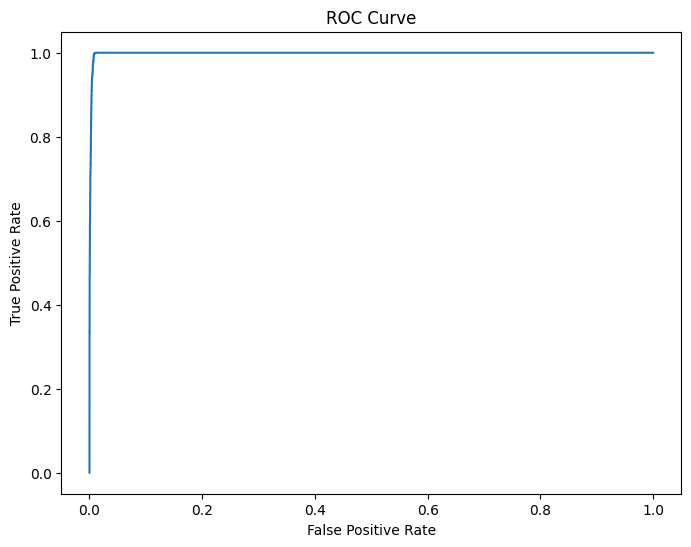

In [110]:
print("Performance on Training Set:")
evaluate_model(model, train_loader, best_threshold=0.5, criterion=criterion)

In [111]:
val_loader_for_eval = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [116]:
trues, predictions, outputs = test_loop(model, val_loader_for_eval, device='cuda', criterion=criterion)

Testing: 100%|██████████| 327/327 [00:19<00:00, 17.00it/s]

🔍 Test Loss: 0.2088 | Accuracy: 98.52%


In [117]:
from sklearn.metrics import precision_recall_curve, f1_score

# y_val: 驗證集真實標籤 (0/1)
# y_val_scores: 模型輸出的機率（sigmoid 後）或 logits
precisions, recalls, thresholds = precision_recall_curve(trues, outputs)

# 計算 F1
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("F1:", f1_scores[best_idx])


Best threshold: 0.437291
Precision: 0.10314557425018288
Recall: 0.09791666666666667
F1: 0.10046312289793126


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    165672
     Failure       0.10      0.10      0.10      1440

    accuracy                           0.98    167112
   macro avg       0.55      0.55      0.55    167112
weighted avg       0.98      0.98      0.98    167112

[[164446   1226]
 [  1299    141]]
ROC AUC: 0.3919


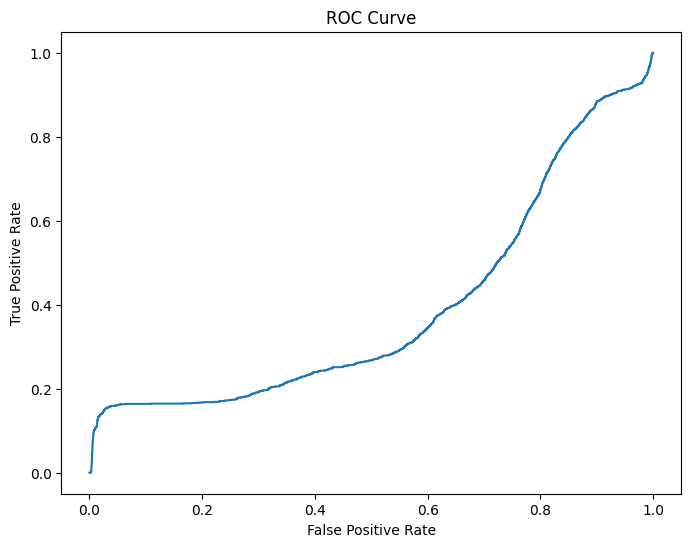

In [121]:
predictions = (outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(trues, predictions, outputs)

Performance on Test Set:


Testing: 100%|██████████| 518/518 [00:26<00:00, 19.24it/s]


🔍 Test Loss: 0.2126 | Accuracy: 97.04%
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98    263035
     Failure       0.00      0.00      0.00      1920

    accuracy                           0.97    264955
   macro avg       0.50      0.49      0.49    264955
weighted avg       0.99      0.97      0.98    264955

[[257098   5937]
 [  1912      8]]
ROC AUC: 0.5723


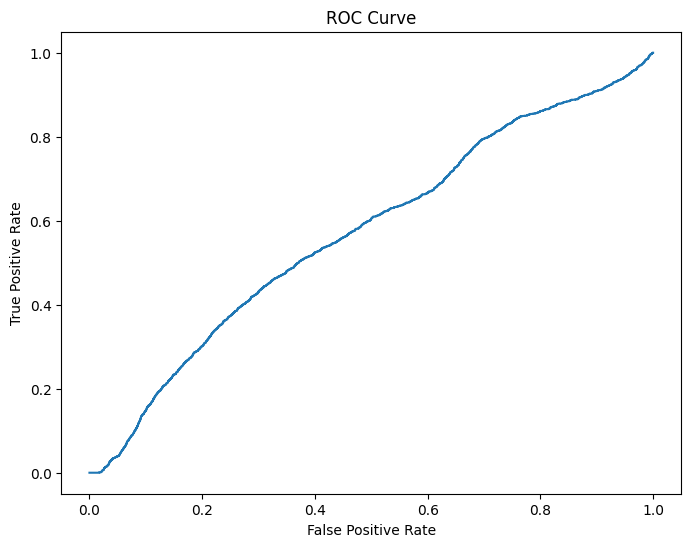

In [119]:
print("Performance on Test Set:")
evaluate_model(model, test_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)